# GLM Illustrative Example

This notebok showcases cedalion's GLM functionality. It creates a GLM design matrix and uses it to simulate a simple timeseries. It then fits different models to the simulated timeseries.

In [31]:
import cedalion
import cedalion.io
import cedalion.nirs
import cedalion.dataclasses as cdc
import cedalion.models.glm as glm
import cedalion.plots as plots
import numpy as np
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as p
import pandas as pd
from cedalion import units
xr.set_options(display_expand_data=False);

## Creating a simple simulated time series

### 1. Build a NDTimeSeries with noise

In [32]:

fs = 10.0 * cedalion.units.Hz # sampling rate
T = 240 * cedalion.units.s # time series length
channel = ["S1D1", "S1D2"] # two channels
chromo = ["HbO", "HbR"] # two chromophores
nsample = int(T * fs)  # number of samples

# create a NDTimeSeries that contains normal distributed noise
ts = cdc.build_timeseries(
    np.random.normal(0, 0.05, (nsample, len(channel), len(chromo))),
    dims=["time", "channel", "chromo"],
    time=np.arange(nsample) / fs,
    channel=channel,
    value_units=units.uM,
    time_units=units.s,
    other_coords={"chromo": chromo},
)
display(ts)

/opt/miniconda3/envs/cedalion_240902/lib/python3.11/site-packages/xarray/core/indexes.py:469: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  index = pd.Index(np.asarray(array), **kwargs)


Magnitude,[[[0.01154245909712605 -0.020306155587889924] [0.003909858787805266 -0.09105877219961815]] [[0.009186493134267336 0.004119193057007706] [0.010448971609350873 -0.0840198642031976]] [[-0.07606282832444872 -0.021505514347761556] [-0.07768415004702849 -0.002633337286070703]] ... [[-0.03511521503580405 0.017981925808688935] [-0.05687883879552191 -0.04072826280342426]] [[0.007706163160079051 -0.009026305824229445] [-0.004328099011460376 -0.09140114491424722]] [[0.018707748568236676 0.04552330070759446] [0.0026420630259632706 -0.03505215555981763]]]
Units,micromolar


### 2. Build the Stimulus DataFrame

Specify two trial types: 'StimA', 'StimB' and define for each 3 trials with a duration of 10s.

The trials get different values assigned, which control the amplitude of the hemodynamic response.

The stimulus Dataframe needs the columns 'trial_type', 'onset', 'duration' and 'value'.

In [33]:
stim = pd.concat(
    (
        pd.DataFrame({"onset": o, "trial_type": "StimA"} for o in [10, 80, 150]),
        pd.DataFrame({"onset": o, "trial_type": "StimB"} for o in [45, 115, 185]),
    )
)

stim["value"] = [0.5, 1, 1.5, 1.25, 0.75, 1.0]
stim["duration"] = 10.
display(stim)

,onset,trial_type,value,duration
0,10,StimA,0.50,10.0
1,80,StimA,1.00,10.0
2,150,StimA,1.50,10.0
0,45,StimB,1.25,10.0
1,115,StimB,0.75,10.0
2,185,StimB,1.00,10.0


### 3. Build a Design Matrix

- Cedalion provides the convenience function `glm.make_design_matrix` to specify model
- two outputs:
  1. a design matrix that applies to all channels, with
    - HRF regressors
    - drift regressors
    - constant term
  2. a list of channel-wise regressors with
    - regressors that can differ between channels. E.g. for the short-distance channel regression one wants to choose for each long channel the content of a short channel. 

The functional form of the HRF regressors is specified by the `basis_function` argument. Please refer to the notebook `glm_basis_functions.ipynb` and the sphinx documentation for more details.

In [34]:
dm, channel_wise_regressors = glm.make_design_matrix(
    ts_long=ts,
    ts_short=None,
    stim=stim,
    geo3d=None,
    basis_function=glm.Gamma(tau=0 * units.s, sigma=5 * units.s, T=10 * units.s),
    drift_order=0,
    short_channel_method=None,
)
# For this use case we want the HbR regressors to be 
# inverted and smaller in amplitude than their HbO counterparts.
dm.loc[:, ["HRF StimA", "HRF StimB"], "HbR"] *= -0.25
display(dm)
display('channel_wise_regressors:', channel_wise_regressors)

<xarray.DataArray (time: 2400, regressor: 3, chromo: 2)> Size: 115kB
0.0 -0.0 0.0 -0.0 1.0 1.0 0.0 -0.0 0.0 ... 1.0 1.0 0.0 -0.0 0.0 -0.0 1.0 1.0
Coordinates:
  * time       (time) float64 19kB 0.0 0.1 0.2 0.3 ... 239.6 239.7 239.8 239.9
  * regressor  (regressor) <U9 108B 'HRF StimA' 'HRF StimB' 'Drift 0'
  * chromo     (chromo) <U3 24B 'HbO' 'HbR'

'channel_wise_regressors:'

None

The design matrix is a `xr.DataArray` with dimensions 'time', 'chromo' (or 'wavelength') and 'regressor'.
Each regressor has a string label for clarity. The convention used by `make_design_matrix` is to
use labels of the form `'HRF <trial_typ> <number>'` for the HRF regressors and `'Drift <number>'` for the
drift components. 

Using such a schema is convenient when one needs to select regressors. If there would be multiple regressors 
for stimulus "StimA" one could distinguish all these from other HRF or drift regressors by selecting labels 
that start with 'HRF StimA'.

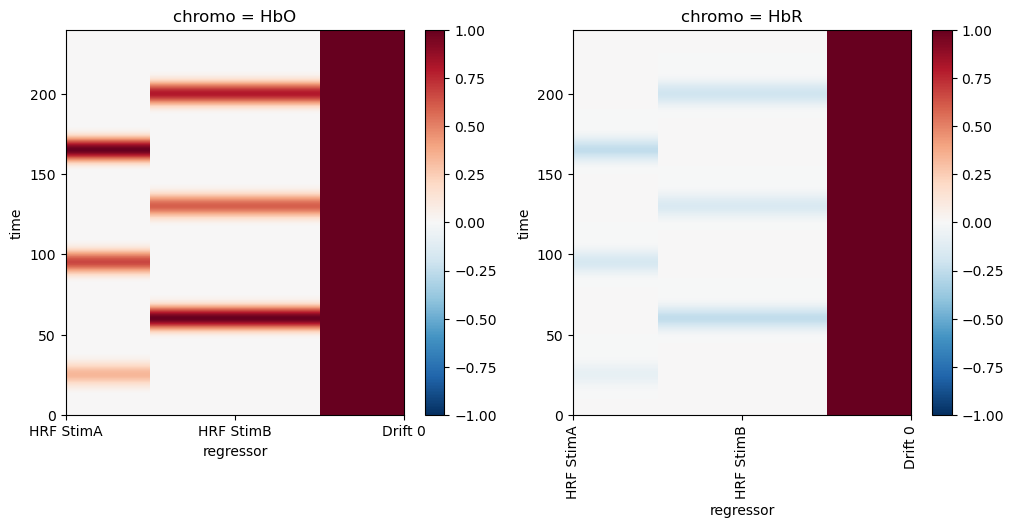

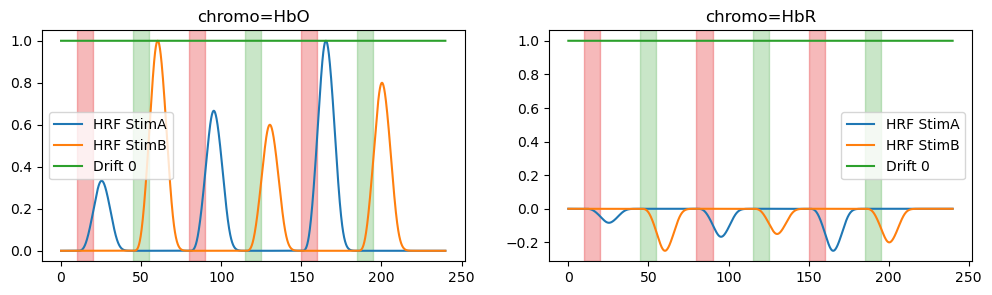

In [35]:
f, ax = p.subplots(1,2,figsize=(12,5))
dm.sel(chromo="HbO").plot(ax=ax[0], vmin=-1, vmax=1, cmap='RdBu_r')
dm.sel(chromo="HbR").plot(ax=ax[1], vmin=-1, vmax=1, cmap='RdBu_r')
p.xticks(rotation=90)
p.show()

f, ax = p.subplots(1,2,figsize=(12,3))
for i,chromo in enumerate(dm.chromo.values):
    for reg in dm.regressor.values:
        ax[i].plot(dm.time, dm.sel(chromo=chromo, regressor=reg), label=reg)
    plots.plot_stim_markers(ax[i], stim, y=1)
    ax[i].set_title(f"chromo={chromo}")
    ax[i].legend()


### 4. Add regressors to time series with noise

The time series has two channels: 'S1D1' and 'S1D2'. In this example
during trial 'StimA' activations should occur only in 'S1D1'. During
'StimB' activations are only in the other channel.

The regressors are added with different offsets and scaling factors.

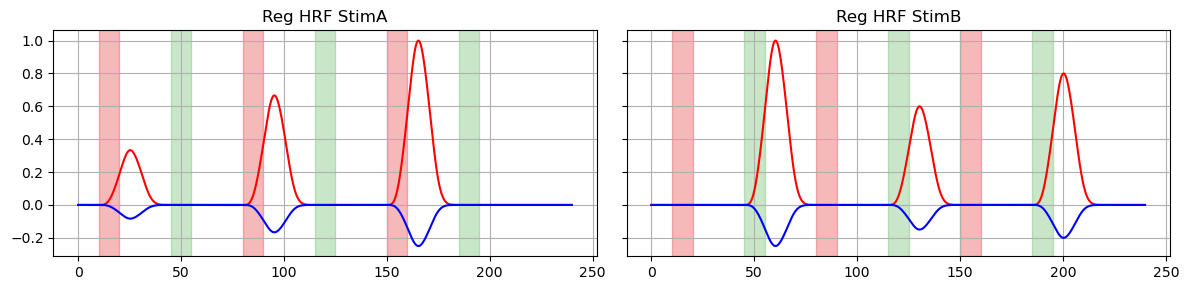

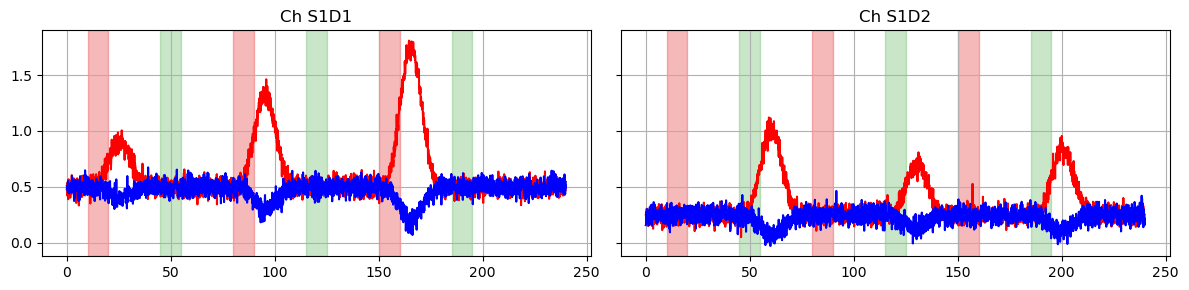

In [36]:
# define offsets and scaling factors
SCALE_STIMA = 1.25
OFFSET_STIMA = 0.5
SCALE_STIMB = 0.75
OFFSET_STIMB = 0.25

# add scaled regressor and offsets to time series, which up to now contains only noise
ts.loc[:, "S1D1", :] += (
    SCALE_STIMA * dm.sel(regressor="HRF StimA").pint.quantify("uM")
    + OFFSET_STIMA * cedalion.units.uM
)
ts.loc[:, "S1D2", :] += (
    SCALE_STIMB * dm.sel(regressor="HRF StimB").pint.quantify("uM")
    + OFFSET_STIMB * cedalion.units.uM
)

# plot original regressors for StimA and StimB
f, ax = p.subplots(1, 2, sharex=True, sharey=True, figsize=(12,3))
for i, reg in enumerate(["HRF StimA", "HRF StimB"]):
    ax[i].plot(dm.time, dm.sel(regressor=reg, chromo="HbO"), "r-")
    ax[i].plot(dm.time, dm.sel(regressor=reg, chromo="HbR"), "b-")
    ax[i].set_title(f"Reg {reg}")
    plots.plot_stim_markers(ax[i], stim, y=1)
    ax[i].grid(True)
p.tight_layout()

# plot the resulting time series
f, ax = p.subplots(1, 2, sharex=True, sharey=True, figsize=(12,3))
for i, ch in enumerate(ts.channel.values):
    ax[i].plot(ts.time, ts.sel(channel=ch, chromo="HbO"), "r-")
    ax[i].plot(ts.time, ts.sel(channel=ch, chromo="HbR"), "b-")
    ax[i].set_title(f"Ch {ch}")
    ax[i].grid(True)
    plots.plot_stim_markers(ax[i], stim, y=1)
p.tight_layout()

## Fitting the GLM - using the same design matrix

The method `glm.fit` is used to fit the GLM to the time series.

- only 'Ordinary Least Squares' (ols) is currently implemented
- more realistic noise models, AR-ILS not available, yet
- no stats, uncertainties

- the returned coefficients / betas are stored again in an xr.DataArray

In [37]:
betas = glm.fit(ts, dm, channel_wise_regressors, noise_model="ols")
display(betas)

<xarray.DataArray (regressor: 3, channel: 2, chromo: 2)> Size: 96B
1.245 1.213 -0.003581 -0.01235 -0.0005189 ... 0.7367 0.5004 0.4974 0.2503 0.2489
Coordinates:
  * regressor  (regressor) <U9 108B 'HRF StimA' 'HRF StimB' 'Drift 0'
  * channel    (channel) <U4 32B 'S1D1' 'S1D2'
  * chromo     (chromo) <U3 24B 'HbO' 'HbR'

Translate the DataArray into a DataFrame to get a rendered table.
Here, the scaling factors and offsets are added as an additional column as
these are the expected values for the coefficients.

In [38]:
df = betas.rename("betas_S1D1").to_dataframe()
# add a column with expected values
df["expected"] = [
    SCALE_STIMA, SCALE_STIMA,
    0.0, 0.0,
    0.0, 0.0,
    SCALE_STIMB, SCALE_STIMB,
    OFFSET_STIMA, OFFSET_STIMA,
    OFFSET_STIMB, OFFSET_STIMB,
]
display(df)

betas_S1D1  expected
regressor channel chromo                      
HRF StimA S1D1    HbO       1.245117      1.25
                  HbR       1.212812      1.25
          S1D2    HbO      -0.003581      0.00
                  HbR      -0.012348      0.00
HRF StimB S1D1    HbO      -0.000519      0.00
                  HbR      -0.019162      0.00
          S1D2    HbO       0.754389      0.75
                  HbR       0.736746      0.75
Drift 0   S1D1    HbO       0.500375      0.50
                  HbR       0.497421      0.50
          S1D2    HbO       0.250271      0.25
                  HbR       0.248926      0.25

In [46]:
# helper function to compare original time series and model prediction
def plot_data_to_fit_comparison(ts, pred, stim):
    f, ax = p.subplots(2,1, sharex=True, figsize=(12,4))
    for i, ch in enumerate(ts.channel.values):
        ax[i].plot(ts.time, ts.sel(channel=ch, chromo="HbO"), "r-")
        ax[i].plot(ts.time, ts.sel(channel=ch, chromo="HbR"), "b-")
        ax[i].plot(pred.time, pred.sel(channel=ch, chromo="HbO"), "-", c="#e41a1c", lw=2)
        ax[i].plot(pred.time, pred.sel(channel=ch, chromo="HbR"), "-", c="#377eb8", lw=2)
        ax[i].set_title(f"Ch {ch}")
        plots.plot_stim_markers(ax[i], stim, y=1)
    p.tight_layout()

<xarray.DataArray (time: 2400, channel: 2, chromo: 2)> Size: 77kB
0.5114 0.4946 0.2574 0.2465 0.5114 0.4946 ... 0.2465 0.5114 0.4946 0.2574 0.2465
Coordinates:
  * time     (time) float64 19kB 0.0 0.1 0.2 0.3 0.4 ... 239.6 239.7 239.8 239.9
  * chromo   (chromo) <U3 24B 'HbO' 'HbR'
  * channel  (channel) <U4 32B 'S1D1' 'S1D2'

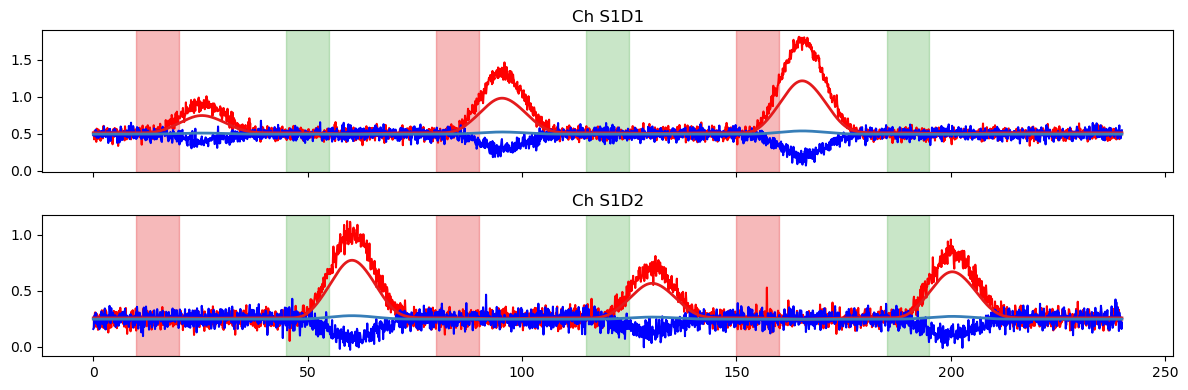

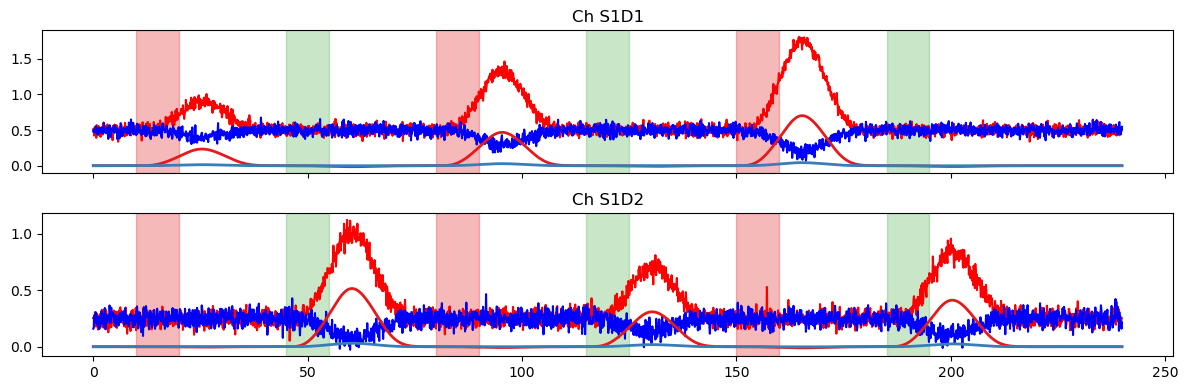

In [47]:
# use all regressors of the design matrix to predict the time series
pred = glm.predict(ts, betas, dm, channel_wise_regressors)
display(pred)
plot_data_to_fit_comparison(ts, pred, stim)


# use only HRF-related regressors, i.e. remove the drift/offset
pred = glm.predict(
    ts,
    # select regressor whose label start with HRF Stim
    betas.sel(regressor=betas.regressor.str.startswith("HRF Stim")),
    dm,
    channel_wise_regressors,
)
plot_data_to_fit_comparison(ts, pred, stim)


## Fitting the GLM - this time using a slightly different model

In [45]:
# copy the stimulus DataFrame and set all values to 1, i.e.
# there is no prior knowledge about amplitude differences between trials
stim_other = stim.copy()
stim_other["value"] = 1.
display(stim_other)

# this design matrix also uses Gamma basis functions but 
# the onset (tau) is delayed and the HRF width (sigma) is longer.
dm_other, channel_wise_regressors_other = glm.make_design_matrix(
    ts,
    None,
    stim_other,
    None,
    basis_function=glm.Gamma(tau=1 * units.s, sigma=7 * units.s, T=10 * units.s),
    drift_order=0,
    short_channel_method=None,
)


betas = glm.fit(ts, dm_other, channel_wise_regressors_other, noise_model="ols")

# display the fitted betas as a DataFrame
display(betas.rename("betas_S1D1").to_dataframe())

,onset,trial_type,value,duration
0,10,StimA,1.0,10.0
1,80,StimA,1.0,10.0
2,150,StimA,1.0,10.0
0,45,StimB,1.0,10.0
1,115,StimB,1.0,10.0
2,185,StimB,1.0,10.0


betas_S1D1
regressor channel chromo            
HRF StimA S1D1    HbO       0.701731
                  HbR      -0.171792
          S1D2    HbO      -0.010971
                  HbR       0.005955
HRF StimB S1D1    HbO      -0.014195
                  HbR       0.008820
          S1D2    HbO       0.513964
                  HbR      -0.123303
Drift 0   S1D1    HbO       0.511412
                  HbR       0.494552
          S1D2    HbO       0.257442
                  HbR       0.246474

<xarray.DataArray (time: 2400, channel: 2, chromo: 2)> Size: 77kB
0.5114 0.4946 0.2574 0.2465 0.5114 0.4946 ... 0.2465 0.5114 0.4946 0.2574 0.2465
Coordinates:
  * time     (time) float64 19kB 0.0 0.1 0.2 0.3 0.4 ... 239.6 239.7 239.8 239.9
  * chromo   (chromo) <U3 24B 'HbO' 'HbR'
  * channel  (channel) <U4 32B 'S1D1' 'S1D2'

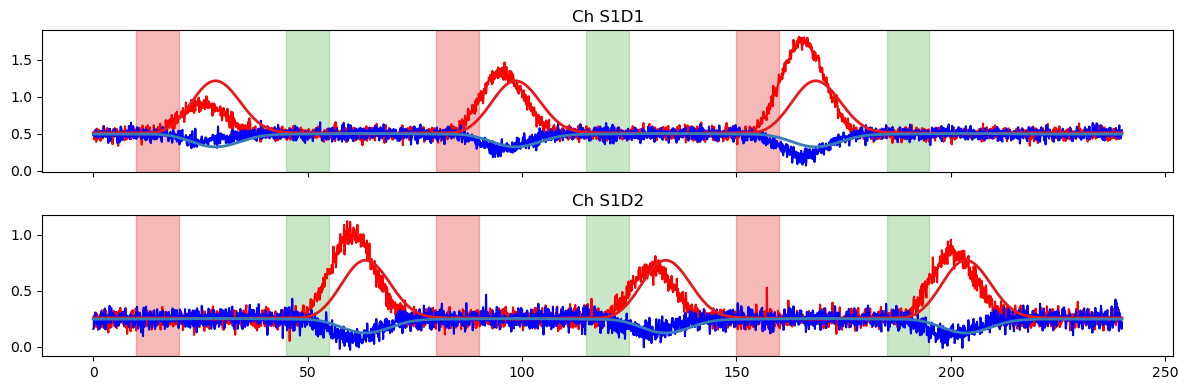

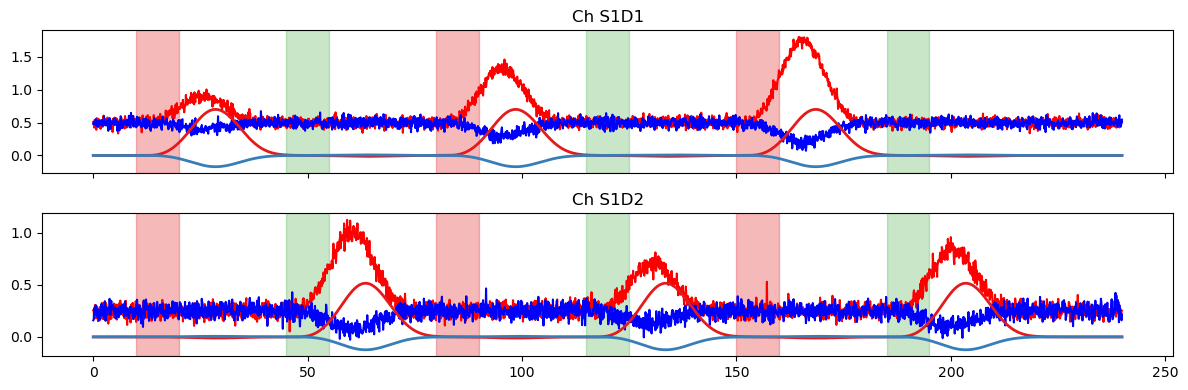

In [41]:
pred = glm.predict(ts, betas, dm_other, channel_wise_regressors_other)
display(pred)
plot_data_to_fit_comparison(ts, pred, stim_other)


pred = glm.predict(
    ts,
    betas.sel(regressor=betas.regressor.str.startswith("HRF Stim")),
    dm_other,
    channel_wise_regressors_other,
)
plot_data_to_fit_comparison(ts, pred, stim_other)


## Fitting with multiple gaussian kernels

(0.0, 90.0)

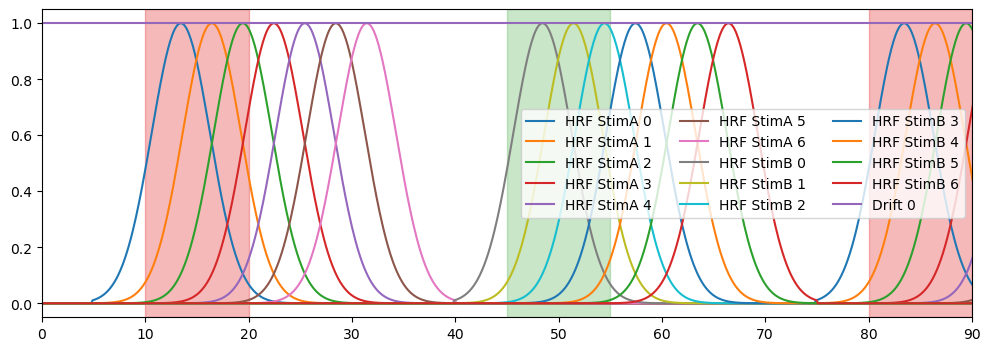

In [42]:
dm_other, channel_wise_regressors_other = glm.make_design_matrix(
    ts,
    None,
    stim_other,
    None,
    basis_function=glm.GaussianKernels(
        t_pre=5 * units.s, t_post=30 * units.s, t_delta=3 * units.s, t_std=2 * units.s
    ),
    drift_order=0,
    short_channel_method=None,
)

betas = glm.fit(ts, dm_other, channel_wise_regressors_other, noise_model="ols")

f,ax = p.subplots(1,1, figsize=(12,4))
for reg in dm_other.regressor.values:
    p.plot(dm_other.time, dm_other.sel(chromo="HbO", regressor=reg), label=reg)
plots.plot_stim_markers(ax, stim_other, y=1.)
p.legend(ncol=3, loc="center right")
p.xlim(0,90)

In [43]:
# translate the xr.DataArray into a pd.DataFrame which are displayed as tables
display(betas.rename("betas_S1D1").to_dataframe())

betas_S1D1
regressor   channel chromo            
HRF StimA 0 S1D1    HbO      -0.001390
                    HbR      -0.009949
            S1D2    HbO      -0.021653
                    HbR       0.000936
HRF StimA 1 S1D1    HbO      -0.001548
                    HbR       0.002196
            S1D2    HbO       0.027697
                    HbR      -0.005346
HRF StimA 2 S1D1    HbO       0.198892
                    HbR      -0.040824
            S1D2    HbO      -0.024706
                    HbR      -0.010173
HRF StimA 3 S1D1    HbO       0.278128
                    HbR      -0.060924
            S1D2    HbO       0.006456
                    HbR       0.033273
HRF StimA 4 S1D1    HbO       0.479033
                    HbR      -0.145794
            S1D2    HbO       0.003083
                    HbR      -0.030211
HRF StimA 5 S1D1    HbO       0.257484
                    HbR      -0.028379
            S1D2    HbO      -0.013243
                    HbR       0.011703
HRF StimA 6 S1D1    HbO       0.217639
                    HbR      -0.075402
            S1D2    HbO       0.008424
                    HbR      -0.000376
HRF StimB 0 S1D1    HbO      -0.007058
                    HbR       0.010253
            S1D2    HbO       0.009083
                    HbR       0.009666
HRF StimB 1 S1D1    HbO       0.020904
                    HbR      -0.024451
            S1D2    HbO      -0.023619
                    HbR      -0.020743
HRF StimB 2 S1D1    HbO      -0.039107
                    HbR       0.026859
            S1D2    HbO       0.174166
                    HbR      -0.034008
HRF StimB 3 S1D1    HbO       0.044486
                    HbR      -0.039767
            S1D2    HbO       0.177194
                    HbR      -0.050843
HRF StimB 4 S1D1    HbO      -0.041774
                    HbR       0.039518
            S1D2    HbO       0.368676
                    HbR      -0.089604
HRF StimB 5 S1D1    HbO       0.017551
                    HbR      -0.019793
            S1D2    HbO       0.168519
                    HbR      -0.034334
HRF StimB 6 S1D1    HbO       0.000819
                    HbR       0.010185
            S1D2    HbO       0.172394
                    HbR      -0.045386
Drift 0     S1D1    HbO       0.502276
                    HbR       0.498375
            S1D2    HbO       0.251589
                    HbR       0.250017

<xarray.DataArray (time: 2400, channel: 2, chromo: 2)> Size: 77kB
0.5023 0.4984 0.2516 0.25 0.5023 0.4984 ... 0.25 0.5023 0.4984 0.2516 0.25
Coordinates:
  * time     (time) float64 19kB 0.0 0.1 0.2 0.3 0.4 ... 239.6 239.7 239.8 239.9
  * chromo   (chromo) <U3 24B 'HbO' 'HbR'
  * channel  (channel) <U4 32B 'S1D1' 'S1D2'

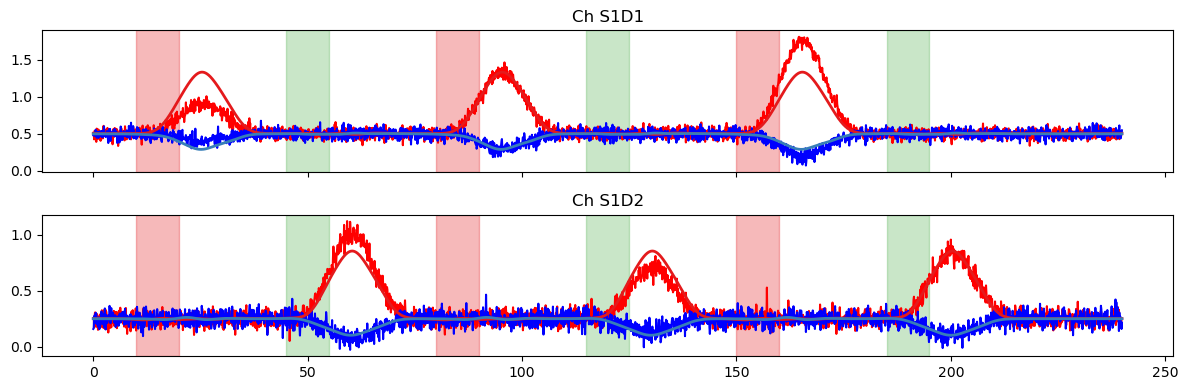

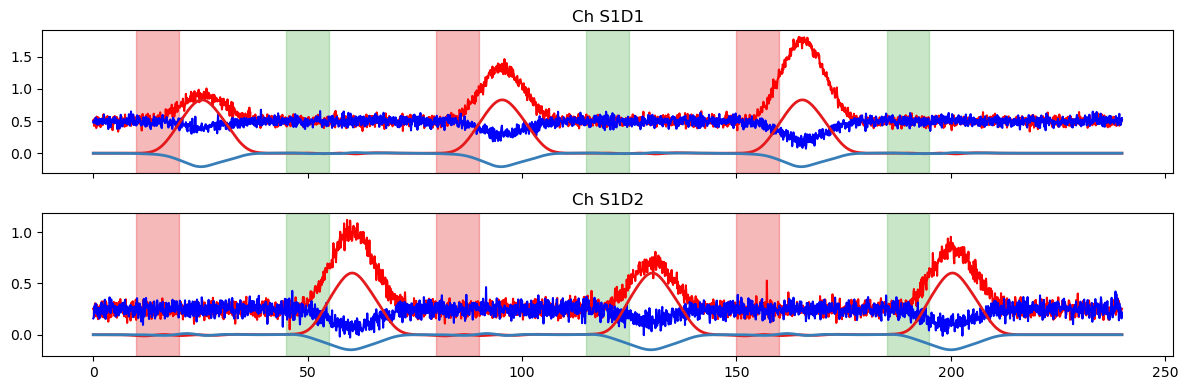

In [44]:
pred = glm.predict(ts, betas, dm_other, channel_wise_regressors_other)
display(pred)
plot_data_to_fit_comparison(ts, pred, stim_other)


pred = glm.predict(
    ts,
    betas.sel(regressor=betas.regressor.str.startswith("HRF Stim")),
    dm_other,
    channel_wise_regressors_other,
)
plot_data_to_fit_comparison(ts, pred, stim_other)
